In [2]:
from pathlib import Path
from glob import glob
from copy import copy

import pandas as pd
import numpy as np
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from NegativeClassOptimization import config, ml, preprocessing

In [3]:
#import data and filter positive sequences
DATASETS_PATH = config.DATA_BASE_PATH / 'Frozen_MiniAbsolut_ML'

In [ ]:
# Calculate Marginal Frequencies for each position
def calculate_marginal_frequencies(array):
    positions = array.shape[1]
    marginal_freqs = {}
    for i in range(positions):
        counts = Counter(array[:, i])
        total = len(array)
        marginal_freqs[i] = {aa: count / total for aa, count in counts.items()}
    return marginal_freqs

array(['AAFYGRWYFDV', 'AAIIYYDYGFD', 'AAIWLRRWYFD', ..., 'YYYGTLDFDVW',
       'YYYGYDDWYLF', 'YYYSNYELGLW'], dtype=object)

Text(0.5, 1.0, 'Marginal frequencies of amino acids in positive sequences')

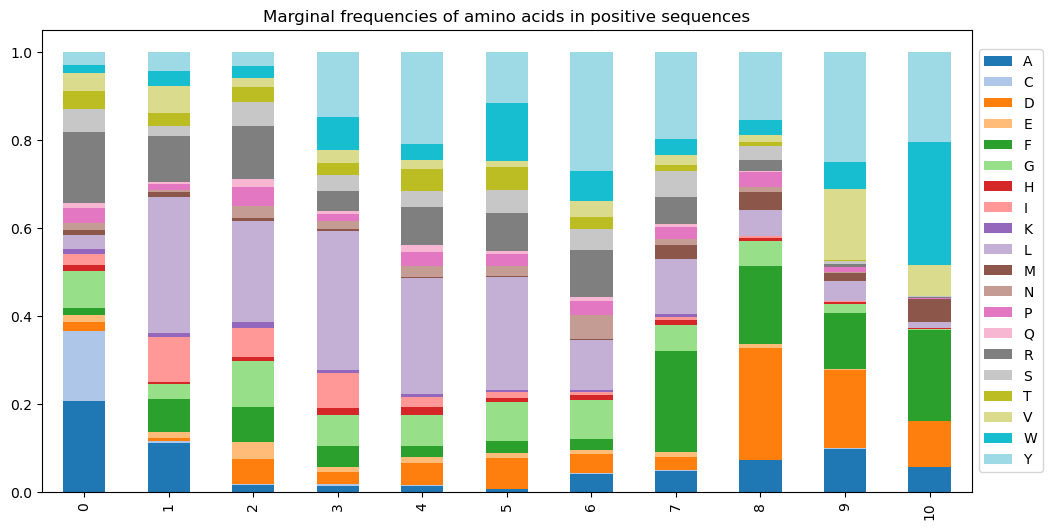

In [109]:
#plot stacked barplot
pos_seq = np.concatenate([df_train_pos.Slide.values, df_train_pos.Slide.values], axis=0)
positive_sequences_array = np.array([list(seq) for seq in pos_seq])
marginal_freqs = calculate_marginal_frequencies(positive_sequences_array)
marginal_freqs_df = pd.DataFrame(marginal_freqs).fillna(0)
marginal_freqs_df.T.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
# move the legend outside and the bottom of the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Marginal frequencies of amino acids in positive sequences')

In [41]:
# Calculate Expected Frequencies for each amino acid pair (i, j) in each position
def calculate_expected_frequencies(marginal_freqs):
    expected_freq = {}
    positions = list(marginal_freqs.keys())
    
    for i in positions:
        for j in positions:
            if i < j:  # Avoid duplicate pairs like (i, j) and (j, i)
                expected_freq[(i, j)] = {}
                for aa_i, prob_i in marginal_freqs[i].items():
                    for aa_j, prob_j in marginal_freqs[j].items():
                        expected_freq[(i, j)][(aa_i, aa_j)] = prob_i * prob_j
    return expected_freq

In [42]:
expected_freq = calculate_expected_frequencies(marginal_freqs)

In [48]:
# Calculate Observed Frequencies
def calculate_observed_frequencies(array):
    positions = array.shape[1]
    observed_freq = defaultdict(lambda: defaultdict(int))  # Nested dictionary for counts
    
    # Count amino acid pairs at all pairs of positions
    for seq in array:
        for i in range(positions):
            for j in range(i + 1, positions):  # Ensure i < j to avoid duplicates
                pair = (seq[i], seq[j])
                observed_freq[(i, j)][pair] += 1

    # Normalize counts to probabilities
    total_sequences = len(array)
    for pos_pair in observed_freq:
        for pair in observed_freq[pos_pair]:
            observed_freq[pos_pair][pair] /= total_sequences

    return {pos_pair: dict(observed_freq[pos_pair]) for pos_pair in observed_freq}


In [49]:
observed_freq = calculate_observed_frequencies(positive_sequences_array)


In [ ]:
#abs value of the difference between observed and expected frequencies
def calculate_diffs(observed_freq, expected_freq):
    diffs = {}
    for pos_pair in observed_freq:
        diffs[pos_pair] = {}
        for pair in observed_freq[pos_pair]:
            diffs[pos_pair][pair] = abs(observed_freq[pos_pair][pair] - expected_freq[pos_pair][pair])
    return diffs

In [95]:
# Identify top linked amino acid pairs
linked_pairs = []
for (i, j), obs_pairs in observed_freq.items():
    for aa_pair, obs_val in obs_pairs.items():
        exp_val = expected_freq[(i, j)].get(aa_pair, 0)
        diff = obs_val - exp_val  # Difference between observed and expected
        linked_pairs.append(((i, j), aa_pair, obs_val, exp_val, diff))

# Convert to DataFrame and sort by difference
linked_df = pd.DataFrame(linked_pairs, columns=['Position Pair', 'Amino Acid Pair', 'Observed', 'Expected', 'Difference'])

In [96]:
ex_for_filtering = linked_df.sort_values(by='Difference', ascending=False).head(6)

In [97]:
def seq_satisfy_filter(seq, filter_df):
    for i, row in filter_df.iterrows():
        pos_pair = row['Position Pair']
        aa_pair = row['Amino Acid Pair']
        if seq[pos_pair[0]] == aa_pair[0] and seq[pos_pair[1]] == aa_pair[1]:
            return True
    return False

In [98]:
df_pos_seq_w_epistasis = df_test[df_test.Slide.apply(lambda x: seq_satisfy_filter(x, ex_for_filtering))]

In [99]:
df_pos_seq_w_epistasis.y.value_counts()

y
0    1339
1    1234
Name: count, dtype: int64

In [70]:
linked_df.sort_values(by='Difference', ascending=False).tail(10)

,Position Pair,Amino Acid Pair,Observed,Expected,Difference
4283,"(1, 4)","(L, L)",0.03735,0.080979,-0.043629
12627,"(4, 8)","(L, D)",0.02290,0.067067,-0.044167
4635,"(1, 5)","(L, L)",0.03365,0.077946,-0.044296
17447,"(8, 10)","(D, F)",0.00715,0.051699,-0.044549
17341,"(8, 9)","(D, D)",0.00010,0.045088,-0.044988
17438,"(8, 10)","(D, Y)",0.00715,0.052207,-0.045057
17494,"(8, 10)","(F, W)",0.00180,0.049671,-0.047871
17724,"(9, 10)","(D, W)",0.00105,0.049351,-0.048301
11555,"(4, 5)","(Y, L)",0.00325,0.053668,-0.050418
16913,"(7, 10)","(Y, W)",0.00510,0.055893,-0.050793


In [100]:
#lets make this a function that can take any df
def get_linked_aa(df):
    seq_array = np.array([list(seq) for seq in df.Slide.values])
    marginal_freqs = calculate_marginal_frequencies(seq_array)
    expected_freq = calculate_expected_frequencies(marginal_freqs)
    observed_freq = calculate_observed_frequencies(seq_array)

    linked_pairs = []
    for (i, j), obs_pairs in observed_freq.items():
        for aa_pair, obs_val in obs_pairs.items():
            exp_val = expected_freq[(i, j)].get(aa_pair, 0)
            diff = obs_val - exp_val  # Difference between observed and expected
            linked_pairs.append(((i, j), aa_pair, obs_val, exp_val, diff))
    
    return pd.DataFrame(linked_pairs, columns=['Position Pair', 'Amino Acid Pair', 'Observed', 'Expected', 'Difference'])

In [110]:
df_train_neg = df_train[df_train['y'] == 0]
df_test_neg = df_test[df_test['y'] == 0]

df_neg = pd.concat([df_train_neg, df_test_neg])

In [111]:
df_linked_neg = get_linked_aa(df_neg)

In [114]:
df_linkage = df_linked_neg.merge(linked_df, on=['Position Pair', 'Amino Acid Pair'], how='inner', suffixes=('_neg', '_pos'))

In [137]:
df_linkage['class_linkage_diff'] = np.abs(np.round(df_linkage['Difference_pos'] - df_linkage['Difference_neg'], 3))

<Axes: >

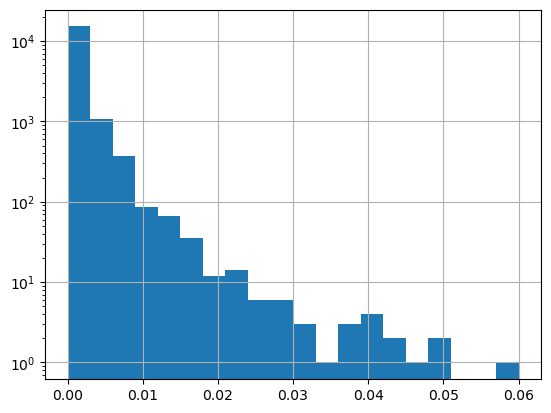

In [139]:
 df_linkage['class_linkage_diff'].hist(bins=20, log=True)

In [140]:
seq_filter = df_linkage.query("class_linkage_diff > 0.03")

In [ ]:
marginal_freqs = calculate_marginal_frequencies(sequences_array)
joint_freqs = calculate_joint_frequencies(sequences_array)
ld_results = calculate_ld(marginal_freqs, joint_freqs)
ld_df = pd.DataFrame([{'Position Pair': pos_pair, 'Amino Acid Pair': aa_pair, 'D': values['D'], 'r2': values['r2']}
                      for pos_pair, aa_dict in ld_results.items()
                      for aa_pair, values in aa_dict.items()])

array(['AAFYGRWYFDV', 'AAIIYYDYGFD', 'AAIWLRRWYFD', ..., 'YYYGTLDFDVW',
       'YYYGYDDWYLF', 'YYYSNYELGLW'], dtype=object)

<Axes: >

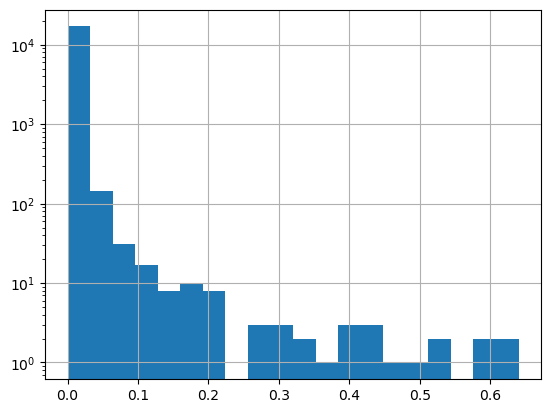

In [ ]:
ld_df.r2.hist(bins=20, log=True)

In [154]:
filtered_ld_df = ld_df.query("r2 > 0.4")

In [159]:
df_test_pos.Slide.apply(lambda x: seq_satisfy_filter(x, filtered_ld_df)).sum()


2657

### Start here

In [55]:
# Step 1: Calculate Marginal Frequencies
def calculate_marginal_frequencies(array):
    positions = array.shape[1]
    marginal_freqs = {}
    for i in range(positions):
        counts = Counter(array[:, i])
        total = len(array)
        marginal_freqs[i] = {aa: count / total for aa, count in counts.items()}
    return marginal_freqs

# Step 2: Calculate Observed Joint Frequencies
def calculate_joint_frequencies(array):
    positions = array.shape[1]
    joint_freqs = defaultdict(lambda: defaultdict(int))
    
    for seq in array:
        for i in range(positions):
            for j in range(i + 1, positions):  # Avoid duplicates (i, j)
                pair = (seq[i], seq[j])
                joint_freqs[(i, j)][pair] += 1

    # Normalize by total number of sequences
    total = len(array)
    for pos_pair in joint_freqs:
        for pair in joint_freqs[pos_pair]:
            joint_freqs[pos_pair][pair] /= total
            
    return {pos_pair: dict(joint_freqs[pos_pair]) for pos_pair in joint_freqs}

# Step 3: Calculate LD Metrics (including r2)
def calculate_ld(marginal_freqs, joint_freqs):
    ld_results = {}
    
    for (i, j), joint_freq_dict in joint_freqs.items():
        ld_results[(i, j)] = {}
        for (aa_i, aa_j), P_ij in joint_freq_dict.items():
            P_i = marginal_freqs[i].get(aa_i, 0)
            P_j = marginal_freqs[j].get(aa_j, 0)
            D = P_ij - (P_i * P_j)  # Linkage disequilibrium coefficient
            if P_i > 0 and P_j > 0:
                r2 = D**2 / (P_i * (1 - P_i) * P_j * (1 - P_j))
            else:
                r2 = 0
            ld_results[(i, j)][(aa_i, aa_j)] = {'D': D, 'r2': r2}
    
    return ld_results

In [56]:
#code that takes pairs of amina acids and positions calculae marginal and joint frequencies
#We calculate marginal frequencies for negatives as usual

def calc_restricted_joint_frequencies(df_aa_pairs, seq_array):
    joint_freqs = defaultdict(lambda: defaultdict(int))
    for i, row in df_aa_pairs.iterrows():
        pos = row['Position Pair']
        aa_pairs = row['Amino Acid Pair']
        #calulate how many times aa_pair in positions pos are present in the sequences
        joint_freqs[pos][aa_pairs] = sum([1 for seq in seq_array if seq[pos[0]] == aa_pairs[0] and seq[pos[1]] == aa_pairs[1]])/len(seq_array)
    return joint_freqs


In [57]:
def seq_satisfy_filter(seq, filter_df):
    for i, row in filter_df.iterrows():
        pos_pair = row['Position Pair']
        aa_pair = row['Amino Acid Pair']
        if seq[pos_pair[0]] == aa_pair[0] and seq[pos_pair[1]] == aa_pair[1]:
            return True
    return False

In [58]:
tasks_dict = {'ONE_VS_NINE': '1v9', 'HIGH_VS_95LOW': 'high_vs_95low', 'HIGH_VS_LOOSER': 'high_vs_looser'}
task_template = {'ONE_VS_NINE': '{ag}__vs__9', 'HIGH_VS_95LOW': '{ag}_high__vs__{ag}_95low', 'HIGH_VS_LOOSER': '{ag}_high__vs__{ag}_looser'}
task_2TASK = {'vs 9': 'ONE_VS_NINE', 'vs Non-binder': 'HIGH_VS_95LOW', 'vs Weak': 'HIGH_VS_LOOSER'}


In [ ]:
for ag in config.ANTIGENS:

    train_path = glob(str(DATASETS_PATH/ f'high_vs_looser/seed_0/split_0/{ag}_high__vs__{ag}_looser/*train_dataset.tsv'))[0]
    test_path = glob(str(DATASETS_PATH/ f'high_vs_looser/seed_0/split_0/{ag}_high__vs__{ag}_looser/*test_dataset.tsv'))[0]
    df_train = pd.read_csv(train_path, sep='\t')
    df_test = pd.read_csv(test_path, sep='\t')
    df_train_pos = df_train[df_train['y'] == 1]
    df_test_pos = df_test[df_test['y'] == 1]
    seqs = np.concatenate([df_train_pos.Slide.values, df_test_pos.Slide.values], axis=0)

    sequences_array = np.array([list(seq) for seq in seqs])

    marginal_freqs = calculate_marginal_frequencies(sequences_array)
    joint_freqs = calculate_joint_frequencies(sequences_array)
    ld_results = calculate_ld(marginal_freqs, joint_freqs)
    ld_df = pd.DataFrame([{'Position Pair': pos_pair, 'Amino Acid Pair': aa_pair, 'D': values['D'], 'r2': values['r2']}
                      for pos_pair, aa_dict in ld_results.items()
                      for aa_pair, values in aa_dict.items()])
    
    filtered_ld_df = ld_df.query("r2 > 0.4")
    df_epistatic_seq = df_test[df_test.Slide.apply(lambda x: seq_satisfy_filter(x, filtered_ld_df))]
    
    ld_df.to_csv(f'linkage_diseq/{ag}_LD.csv', index=False)
    df_epistatic_seq.to_csv(f'linkage_diseq/{ag}_epistatic_seq.csv', index=False)

In [93]:
#lets see the R2 for negative data
for ag in config.ANTIGENS:

    #test_path = glob(str(DATASETS_PATH/ f'high_vs_looser/seed_0/split_0/{ag}_high__vs__{ag}_looser/*test_dataset.tsv'))[0]
    test_path = glob(str(DATASETS_PATH/ f'high_vs_95low/seed_0/split_0/{ag}_high__vs__{ag}_95low/*test_dataset.tsv'))[0]
    df_test = pd.read_csv(test_path, sep='\t')
    df_test_neg = df_test[df_test['y'] == 0]
    seqs = np.array([list(seq) for seq in df_test_neg.Slide.values])

    marginal_freqs = calculate_marginal_frequencies(seqs)
    
    ld_df_pos = pd.read_csv(f'./linkage_diseq/{ag}_LD.csv')
    ld_df_pos['Position Pair'] = ld_df_pos['Position Pair'].apply(eval)
    ld_df_pos['Amino Acid Pair'] = ld_df_pos['Amino Acid Pair'].apply(eval)
    df_aa_pairs = ld_df_pos[['Position Pair', 'Amino Acid Pair']].copy()


    joint_freqs = calc_restricted_joint_frequencies(df_aa_pairs, seqs)

    ld_results = calculate_ld(marginal_freqs, joint_freqs)
    ld_df_neg = pd.DataFrame([{'Position Pair': pos_pair, 'Amino Acid Pair': aa_pair, 'D': values['D'], 'r2': values['r2']}
                      for pos_pair, aa_dict in ld_results.items()
                      for aa_pair, values in aa_dict.items()])
    
    ld_df_pos.merge(ld_df_neg, on=['Position Pair', 'Amino Acid Pair'], how='inner', suffixes=('_pos', '_neg')).to_csv(f'linkage_diseq/{ag}_LD_neg_pos_nb.csv', index=False)


In [16]:
#plot barplot of r2 values that are above 0.4 for each antigen
coupled_positions_count = dict()
for ag in config.ANTIGENS:
    df = pd.read_csv(f'linkage_diseq/{ag}_epistatic_seq.csv')
    n = len(df)
    coupled_positions_count[ag] = n

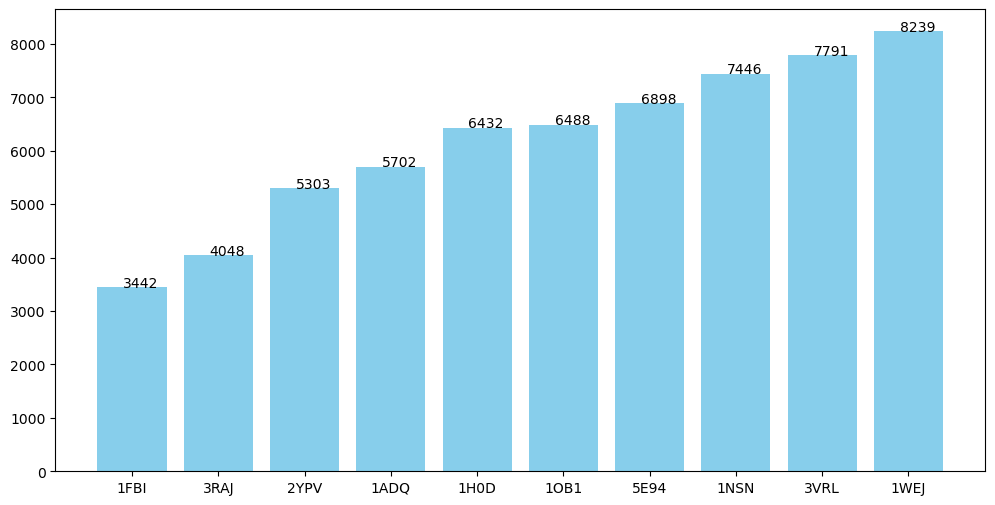

In [17]:
#plot barplot sort by values and write the values on top of the bars
coupled_positions_count = {k: v for k, v in sorted(coupled_positions_count.items(), key=lambda item: item[1])}
plt.figure(figsize=(12, 6))
plt.bar(coupled_positions_count.keys(), coupled_positions_count.values(), color='skyblue')
for i, v in enumerate(coupled_positions_count.values()):
    plt.text(i - 0.1, v + 0.5, str(v))

In [59]:
def model_mistakes_on_linked(ag, task, seed, split, linked_seq_df):
    TASK = task_2TASK[task]
    error_rate_ag =dict()
    model_path = config.DATA_ML / f"{tasks_dict[TASK]}/seed_{seed}/split_{split}/{task_template[TASK].format(ag=ag)}/trained_model/data/model.pth"
    model = torch.load(model_path, map_location=torch.device('cpu'))

    linked_seq_df['X'] = linked_seq_df.Slide.apply(lambda x: preprocessing.onehot_encode(x))

    with torch.no_grad():
        X = np.array(linked_seq_df["X"].tolist())
        X_tensor = torch.tensor(X, dtype=torch.float32)  # type: ignore
        y_pred = model(X_tensor).round().detach().numpy().reshape(-1)
        y_true = linked_seq_df["y"].values
        error_rate = np.mean(y_pred != y_true)
    return error_rate

In [22]:
linked_seq_df

,Slide,binds_a_pos_ag,Slide_onehot,X,y
0,AAGLYWYFDVW,0,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,AAKLRWYFDVW,0,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,AAQVPWYFDVW,0,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
3,ACGYHWYFDVW,0,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,ACSYGWYFDVW,0,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...,...,...,...
7786,YYSLLYAMDDW,0,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
7787,YYSNFFLFDYW,1,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
7788,YYVLGWYFDVW,0,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
7789,YYYGNFLFDYW,0,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [23]:
error_by_ag_task = []
for ag in config.ANTIGENS:
    for task in ['vs Weak', 'vs Non-binder']:
        seed = 0
        split =0
        linked_seq_df = pd.read_csv(f'linkage_diseq/{ag}_epistatic_seq.csv')
        error_rate = model_mistakes_on_linked(ag, task, seed, split, linked_seq_df)
        error_by_ag_task.append({'Antigen': ag, 'Task': task, 'Error Rate': error_rate})

error_by_ag_task_df = pd.DataFrame(error_by_ag_task)


In [24]:
error_by_ag_task_df

,Antigen,Task,Error Rate
0,3VRL,vs Weak,0.043768
1,3VRL,vs Non-binder,0.260044
2,1NSN,vs Weak,0.077357
3,1NSN,vs Non-binder,0.228176
4,3RAJ,vs Weak,0.097579
5,3RAJ,vs Non-binder,0.315464
6,5E94,vs Weak,0.076544
7,5E94,vs Non-binder,0.270948
8,1H0D,vs Weak,0.105255
9,1H0D,vs Non-binder,0.267257


Text(0.5, 1.0, 'Error rate on positive sequences with Linkage Disequilibrium > 0.4')

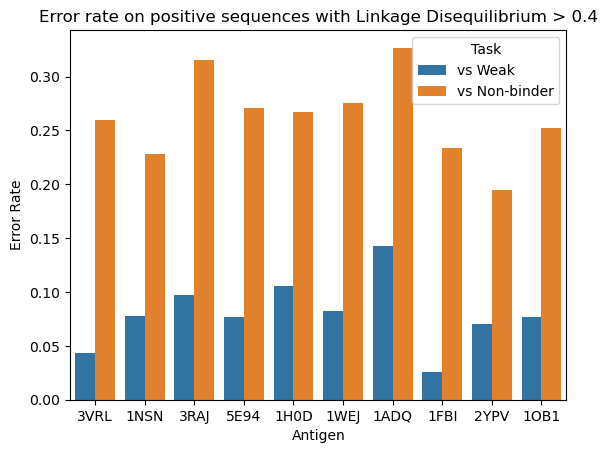

In [109]:
sns.barplot(x='Antigen', y='Error Rate', hue='Task', data=error_by_ag_task_df)
plt.title('Error rate on positive sequences with Linkage Disequilibrium > 0.4')

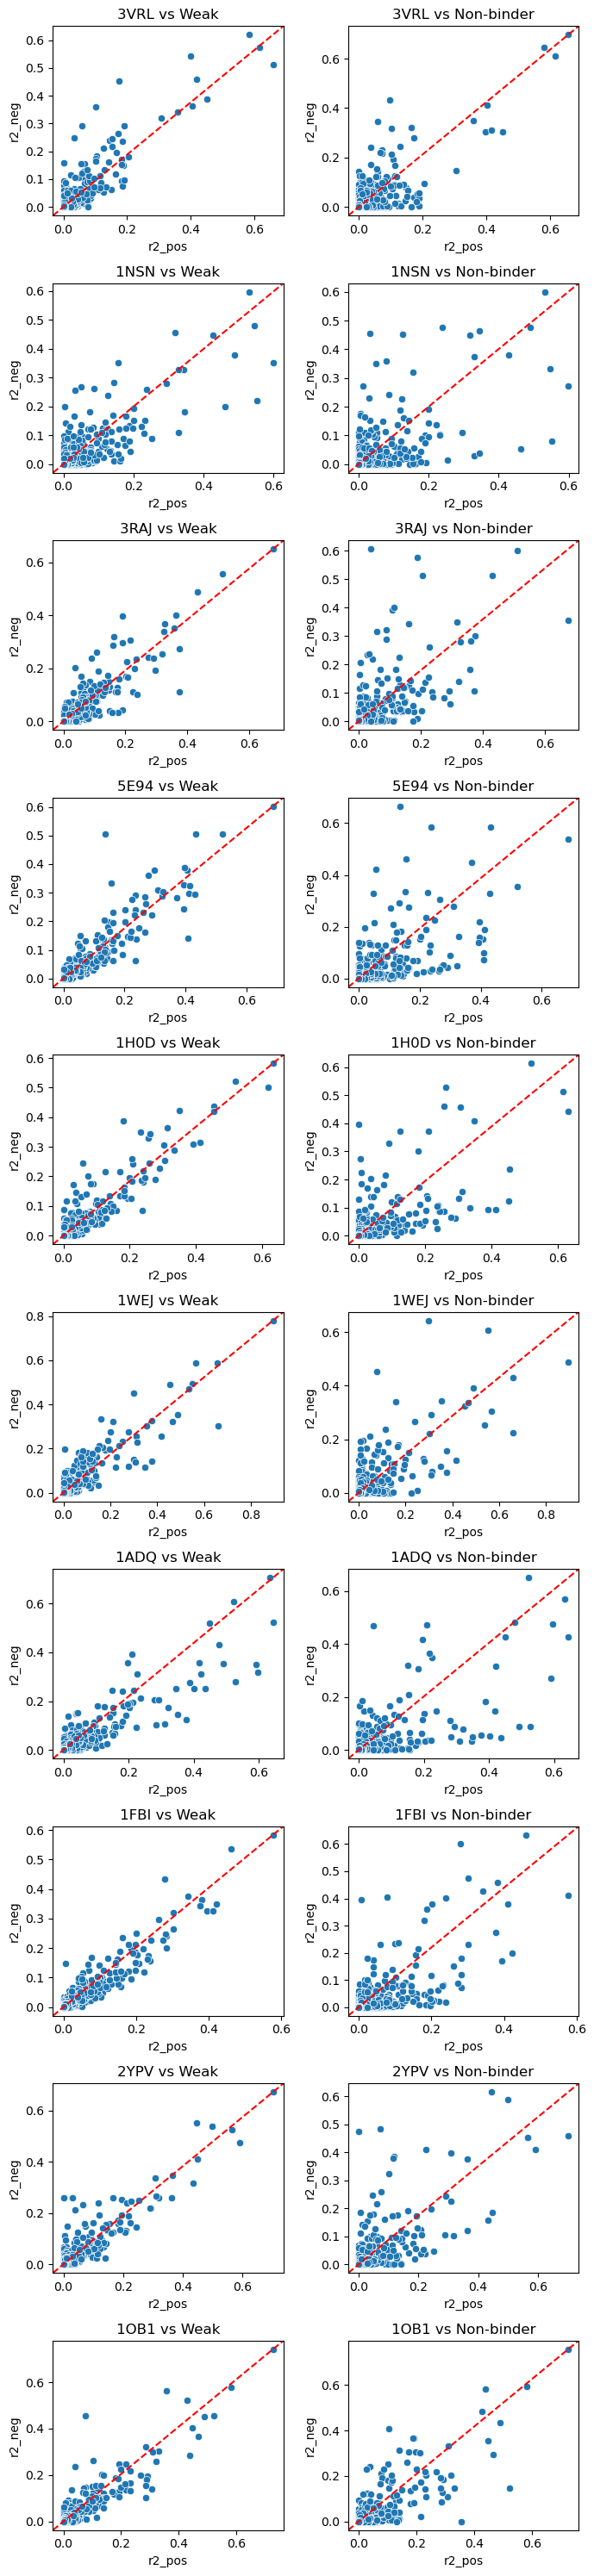

In [121]:
#make it tight 
fig, ax = plt.subplots(10, 2, figsize=(7, 30))
for i, ag in enumerate(config.ANTIGENS):
    df_ld_nb = pd.read_csv(f'linkage_diseq/{ag}_LD_neg_pos_nb.csv')
    df_ld_wk = pd.read_csv(f'linkage_diseq/{ag}_LD_neg_pos.csv')

    sns.scatterplot(x='r2_pos', y='r2_neg', data=df_ld_wk, ax=ax[i, 0])
    sns.scatterplot(x='r2_pos', y='r2_neg', data=df_ld_nb, ax=ax[i,1])
    ax[i, 0].set_title(f"{ag} vs Weak")
    ax[i, 1].set_title(f"{ag} vs Non-binder")
    #add diagonal line
    ax[i, 0].plot([0, 1], [0, 1], transform=ax[i, 0].transAxes, ls="--", c="red")
    ax[i, 1].plot([0, 1], [0, 1], transform=ax[i, 1].transAxes, ls="--", c="red")

fig.tight_layout()

# it is important to account for sign of the D as well


In [105]:
error_onall_pos_by_ag_task = []
for ag in config.ANTIGENS:
    for task in ['vs Weak', 'vs Non-binder']:
        seed = 0
        split =0
        test_path = glob(str(DATASETS_PATH/ f'high_vs_looser/seed_0/split_0/{ag}_high__vs__{ag}_looser/*test_dataset.tsv'))[0]
        df_test = pd.read_csv(test_path, sep='\t')
        df_test_pos = df_test[df_test['y'] == 1].copy()

        error_rate = model_mistakes_on_linked(ag, task, seed, split, df_test_pos)
        error_onall_pos_by_ag_task.append({'Antigen': ag, 'Task': task, 'Error Rate': error_rate})

error_onall_pos_by_ag_task = pd.DataFrame(error_onall_pos_by_ag_task)

Text(0.5, 1.0, 'Error rate on all positive sequences')

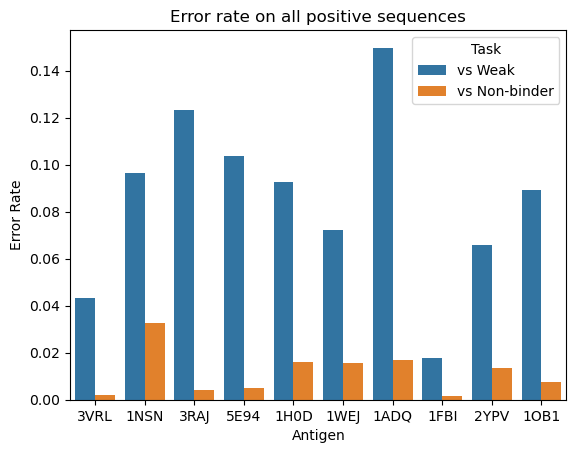

In [ ]:
sns.barplot(x='Antigen', y='Error Rate', hue='Task', data=error_onall_pos_by_ag_task)
plt.title('Error rate on all positive sequences')

In [73]:
# how error rate change with r2
#upload positive test data
ag = '1FBI'
seed = 0
split = 0
test_path = glob(str(DATASETS_PATH/ f'high_vs_looser/seed_0/split_0/{ag}_high__vs__{ag}_looser/*test_dataset.tsv'))[0]
df_test = pd.read_csv(test_path, sep='\t')
df_test_pos = df_test[df_test['y'] == 1].copy()

#upload the LD data
df_ld = pd.read_csv(f'linkage_diseq/{ag}_LD.csv')
df_ld['Position Pair'] = df_ld['Position Pair'].apply(eval)
df_ld['Amino Acid Pair'] = df_ld['Amino Acid Pair'].apply(eval)
#convert to dict
df_ld_dict = df_ld.set_index(['Position Pair', 'Amino Acid Pair']).to_dict('index')

#for each df_test_pos.Slide create a list of 2aa pairs [((pos1, pos2), (aa1, aa2)), ...]
def get_aa_pairs(seq):
    aa_pairs = []
    for i in range(len(seq)):
        for j in range(i+1, len(seq)):
            aa_pairs.append(((i, j), (seq[i], seq[j])))
    return aa_pairs

df_test_pos['aa_pairs'] = df_test_pos.Slide.apply(get_aa_pairs)

#look up r2 for each present aa pair[
df_test_pos['aa_r2s'] = df_test_pos['aa_pairs'].apply(lambda pairs: [df_ld_dict.get(pair, {'r2': np.nan})['r2'] for pair in pairs])

r2_cutoffs = np.arange(0, 1, 0.1)

#go over all r2s list and check does any of r2 satisfy each cutoff
error_rate_by_r2 = []
for r2_cutoff in r2_cutoffs:
    df_test_pos[f'{r2_cutoff}_cutoff'] = df_test_pos['aa_r2s'].apply(lambda r2s: (np.array(r2s)>r2_cutoff).sum() > 0)

#calculate error rate for each cutoff for 'vs Weak' and 'vs Non-binder' models
    linked_seq_df = df_test_pos[df_test_pos[f'{r2_cutoff}_cutoff']].copy()
    if len(linked_seq_df) != 0:
        for task in ['vs Weak', 'vs Non-binder']:
            error_rate = model_mistakes_on_linked(ag, task, seed, split, linked_seq_df)
            error_rate_by_r2.append({'r2_cutoff': r2_cutoff, 'Task': task, 'Error Rate': error_rate})

    error_rate_by_r2_df = pd.DataFrame(error_rate_by_r2)




([<matplotlib.axis.XTick at 0x293471040>,
 [Text(0, 0, '0.0'),
  Text(1, 0, '0.1'),
  Text(2, 0, '0.2'),
  Text(3, 0, '0.3'),
  Text(4, 0, '0.4'),
  Text(5, 0, '0.5'),
  Text(6, 0, '0.6'),
  Text(7, 0, '0.7'),
  Text(8, 0, '0.8'),
  Text(9, 0, '0.9')])

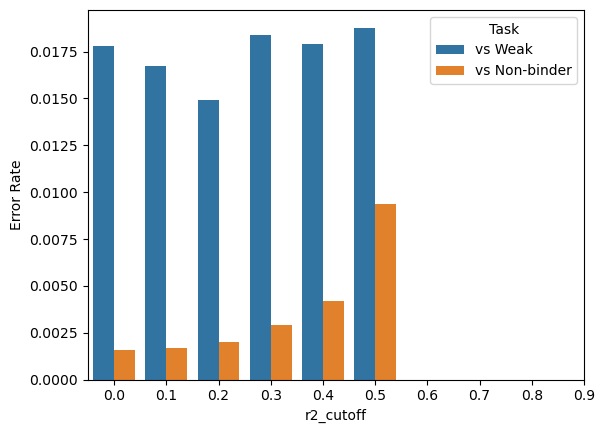

In [74]:
#error_rate_by_r2_df
#plot barplot hue Task and x r2_cutoff 
sns.barplot(x='r2_cutoff', y='Error Rate', hue='Task', data=error_rate_by_r2_df)
#rename xticks
plt.xticks(range(10), [f'{r2:.1f}' for r2 in r2_cutoffs])

In [ ]:
#look for errors.... Clean the code tomorrow